<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/05.%20Sarria-Sant%20Gervasi/Forecasting_(Indicador_46).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Esperanza de vida)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','AñosEspVida']]

In [5]:
df_var = df_sel.dropna()

In [6]:
df_var.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4968 entries, 0 to 5255
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   4968 non-null   int64  
 1   Trimestre             4968 non-null   int64  
 2   Mes                   4968 non-null   int64  
 3   Codi_Districte        4968 non-null   int64  
 4   Nom_Districte         4968 non-null   object 
 5   Codi_Barri            4968 non-null   int64  
 6   Nom_Barri             4968 non-null   object 
 7   Compraventa_Unitario  4968 non-null   float64
 8   AñosEspVida           4968 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 388.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_var['Fecha'] = pd.to_datetime(df_var['Any'].astype(str) + '-' + df_var['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_varI = df_var.set_index('Fecha')

In [9]:
df_varI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,AñosEspVida
Fecha,,,,,,,,,
2014-01-01,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-02-01,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-03-01,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-04-01,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,80.7
2014-05-01,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,80.7


### Analisis Exploratorio

Filtramos los datos por el distrito de Sarrià-Sant Gervasi -> Codi_Districte = 5

In [10]:
df_varFiltrado = df_varI[df_varI['Codi_Districte'] == 5]

In [11]:
# Agrupamos los datos
df =df_varFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,AñosEspVida
Fecha,,
2014-01-01,4198.150000,84.416667
2014-02-01,4198.150000,84.416667
2014-03-01,4198.150000,84.416667
2014-04-01,4246.083333,84.416667
2014-05-01,4246.083333,84.416667


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  72 non-null     float64
 1   AñosEspVida           72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB


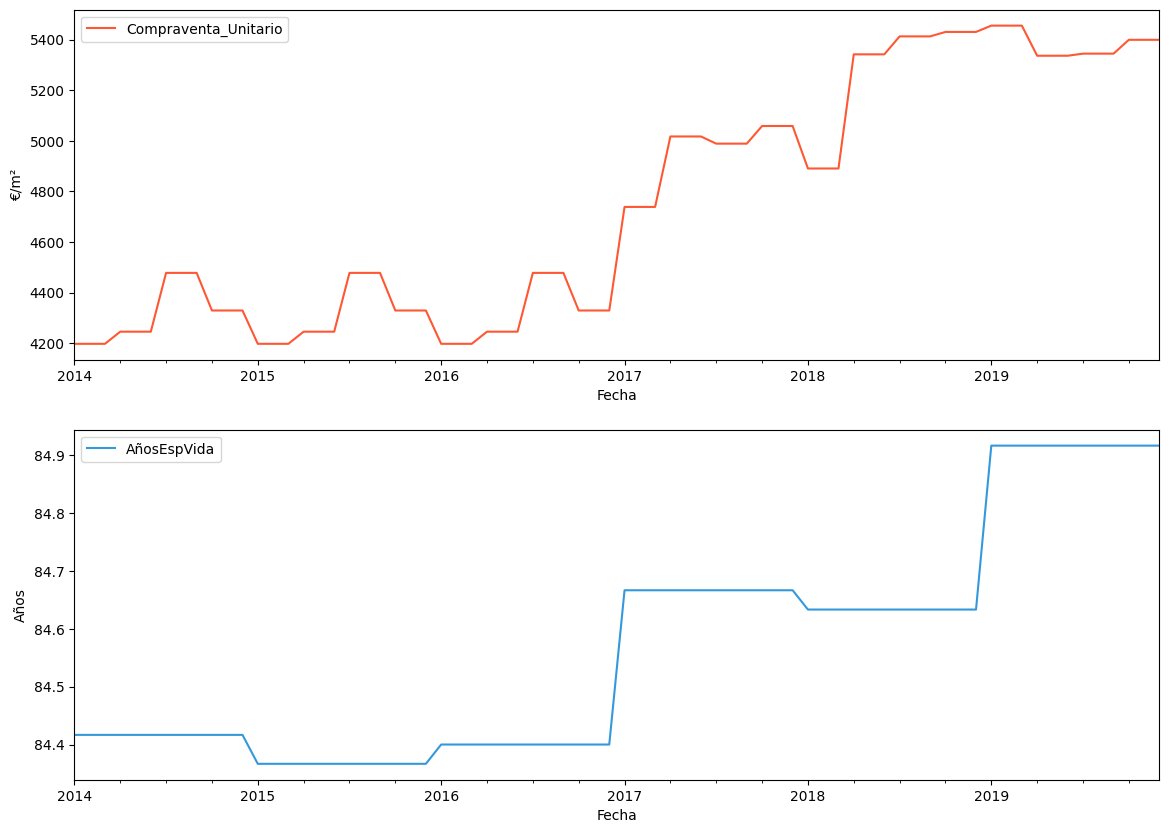

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', 'Años']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,AñosEspVida
Compraventa_Unitario,1.000000,0.895532
AñosEspVida,0.895532,1.000000


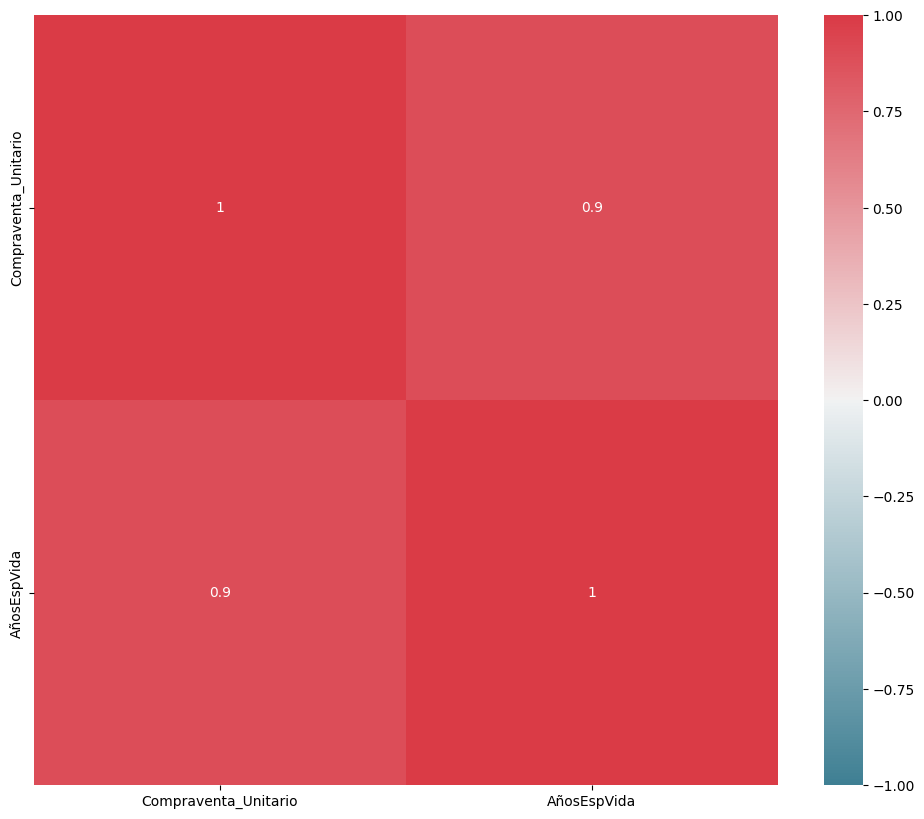

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

Tambien podemos observar como las 2 variables tienen una alta correlacion, concretamente un 89.5532% de correlacion

### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [17]:
fecha_division = '2019-07-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(66, 2) (6, 2)


###Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
cointegration_test(X_train[['Compraventa_Unitario', 'AñosEspVida']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  5.66      > 12.3212   =>   False
AñosEspVida >  1.79      > 4.1296    =>   False


* **Compraventa_Unitario**: No hay suficiente evidencia estadística para rechazar la hipótesis nula de no cointegración. Esto sugiere que "Compraventa_Unitario" no tiene una relación de equilibrio estacionario de largo plazo con las otras series en el sistema.
* **AñosEspVida**: Similarmente, "AñosEspVida" tampoco muestra evidencia de cointegración. No existe una combinación lineal estacionaria que vincule esta serie con otras en el sistema a largo plazo.

Para un análisis conjunto que aún considera las interacciones entre múltiples series no cointegradas, usaremos un modelo VAR (Vector Autoregressive) o VARMA (Vector Autoregressive Moving Average) y descartaremos el modelo VECM (Vector Error Correlation Model), pero primero transformaremos comprobaremos y transformaremos por diferenciacion las veces necesrarias para convertir las series en estacionarias

### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.835031
Serie de tiempo AñosEspVida
p-value: 0.945246


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,AñosEspVida
Fecha,,
2014-02-01,0.000000,0.0
2014-03-01,0.000000,0.0
2014-04-01,47.933333,0.0
2014-05-01,0.000000,0.0
2014-06-01,0.000000,0.0


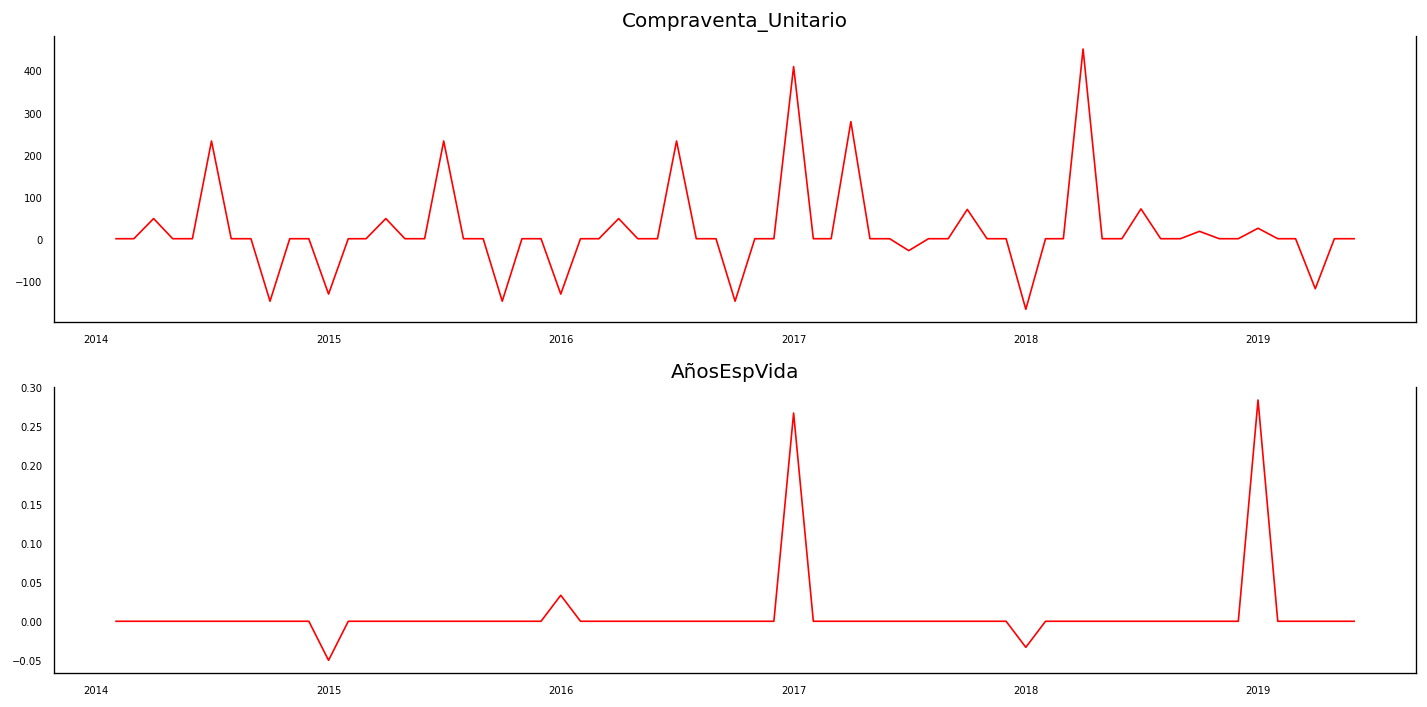

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable AñosEspVida
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.





In [25]:
from statsmodels.tsa.api import VAR

In [26]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [27]:
modelsel=model.select_order(12)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,3.488*,3.563*,32.73*,3.517*
1,3.637,3.860,37.98,3.723
2,3.785,4.157,44.08,3.928
3,3.891,4.412,49.12,4.091
4,4.038,4.707,57.10,4.295
5,4.185,5.002,66.48,4.499
6,4.226,5.192,69.84,4.598
7,4.373,5.488,81.83,4.802
8,4.519,5.783,96.20,5.006
9,4.160,5.573,68.51,4.704


El criterio AIC, FPE, BIC y el HQIC  sugieren que el mejor modelo es con 0 rezagos.

#### Ajustando el modelo

In [28]:
res = model.fit(maxlags=12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, May, 2024
Time:                     16:42:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.12038
Nobs:                     53.0000    HQIC:                   4.97640
Log likelihood:          -213.340    FPE:                    83.4148
AIC:                      4.26161    Det(Omega_mle):         38.5128
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           28.675309        27.179486            1.055           0.291
L1.Compraventa_Unitario         -0.052515         0.207077           -0.254           0.800
L

La correlación entre los residuos de "Compraventa_Unitario" y "AñosEspVida" es bastante alta, con un valor de 0.914434. Esto sugiere una correlación muy fuerte entre los residuos de estas dos variables en tu modelo.

In [29]:
res.is_stable()

True

In [30]:
X_train.columns

Index(['Compraventa_Unitario', 'AñosEspVida'], dtype='object')

###### Causalidad de Granger

In [31]:
grangercaus=res.test_causality(['AñosEspVida'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.986,1.930,0.043,"(12, 56)"


In [32]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['AñosEspVida'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.2282,1.930,0.996,"(12, 56)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede causar la otra serie temporal

###### Matriz de causalidad de Granger


In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=12
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,AñosEspVida_x
Compraventa_Unitario_y,1.0,0.8841
AñosEspVida_y,0.0,1.0000


Como se puede ver en la matriz de causalidad de Granger, podemos considerar que la serie de Compraventa_Unitario causa cambios en la serie de AñosEspVida y viceversa.

####Diagnosis del modelo


###### Residuos

In [34]:
residuals=res.resid

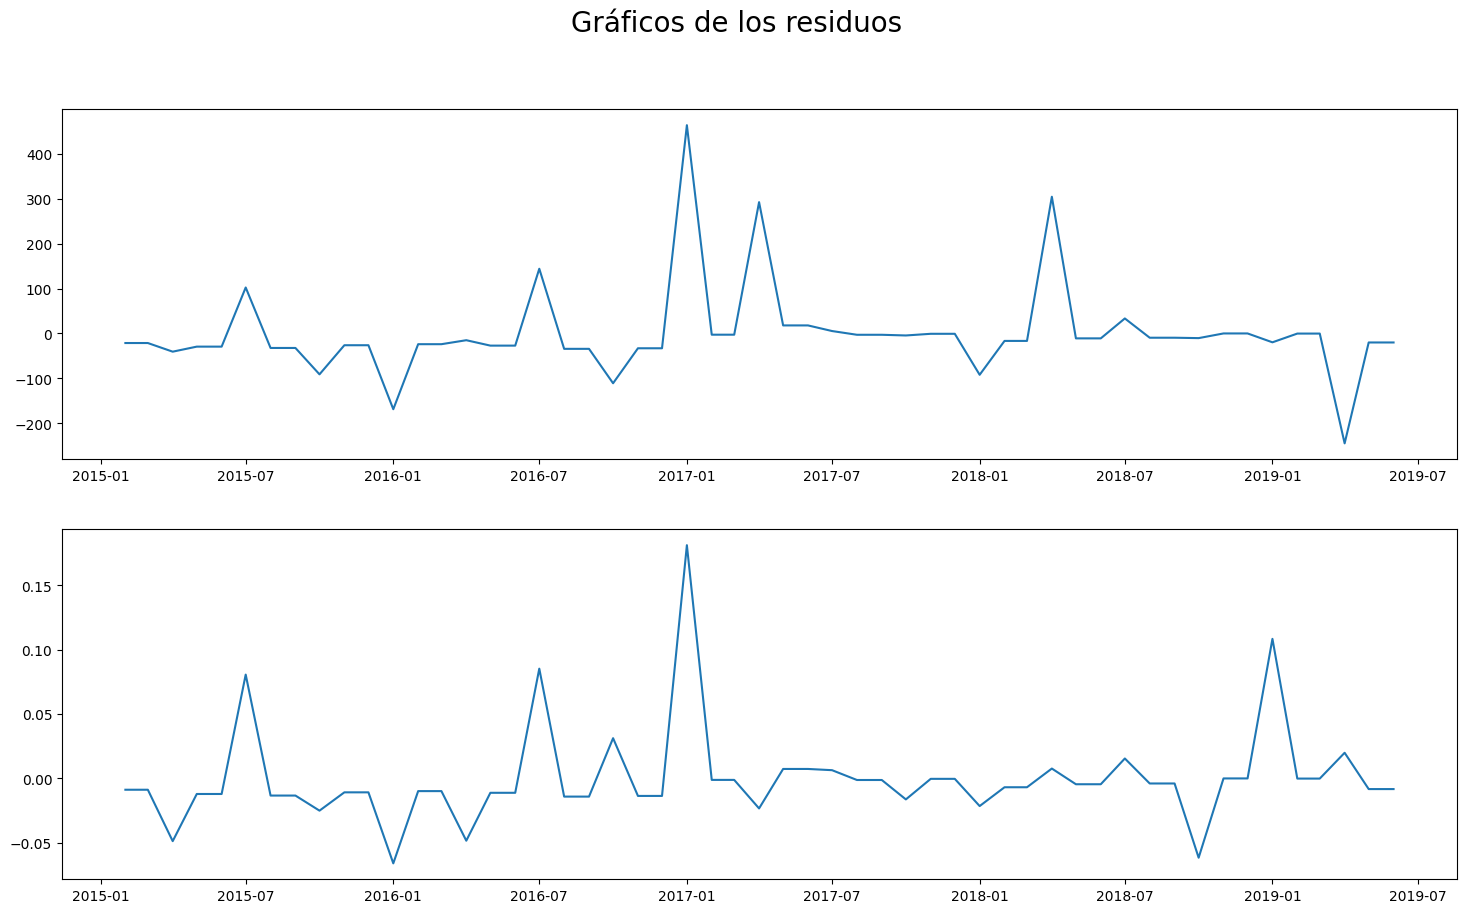

In [35]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [36]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[5.801033610413597e-10, 1.3237922976114702e-10]

Todos los p-valores son < 0.05 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


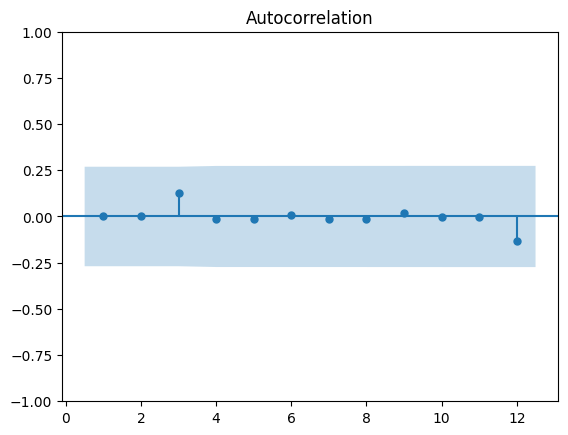

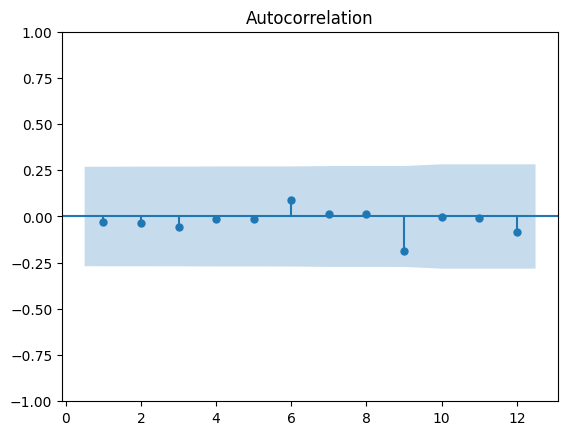

In [37]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


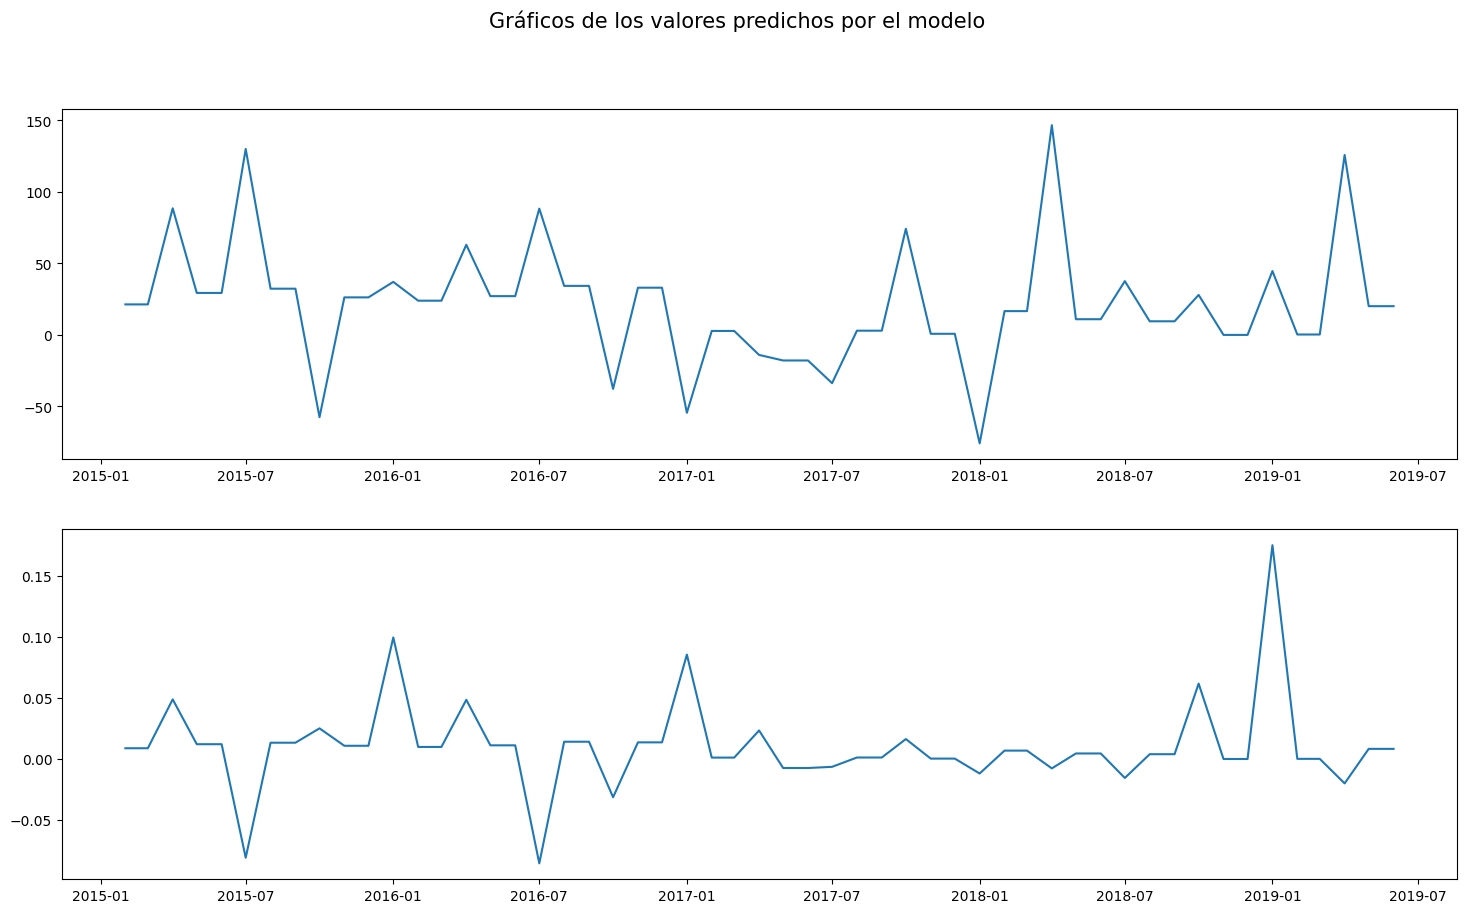

In [38]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [39]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=6)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 12
Predicciones:


,Compraventa_Unitario_pred,AñosEspVida_pred
Fecha,,
2019-07-01,-82.440045,0.002734
2019-08-01,42.653140,0.017579
2019-09-01,40.959528,0.016881
2019-10-01,102.836481,-0.195010
2019-11-01,43.727642,0.018444
2019-12-01,41.291175,0.017423


<Figure size 1200x1000 with 0 Axes>

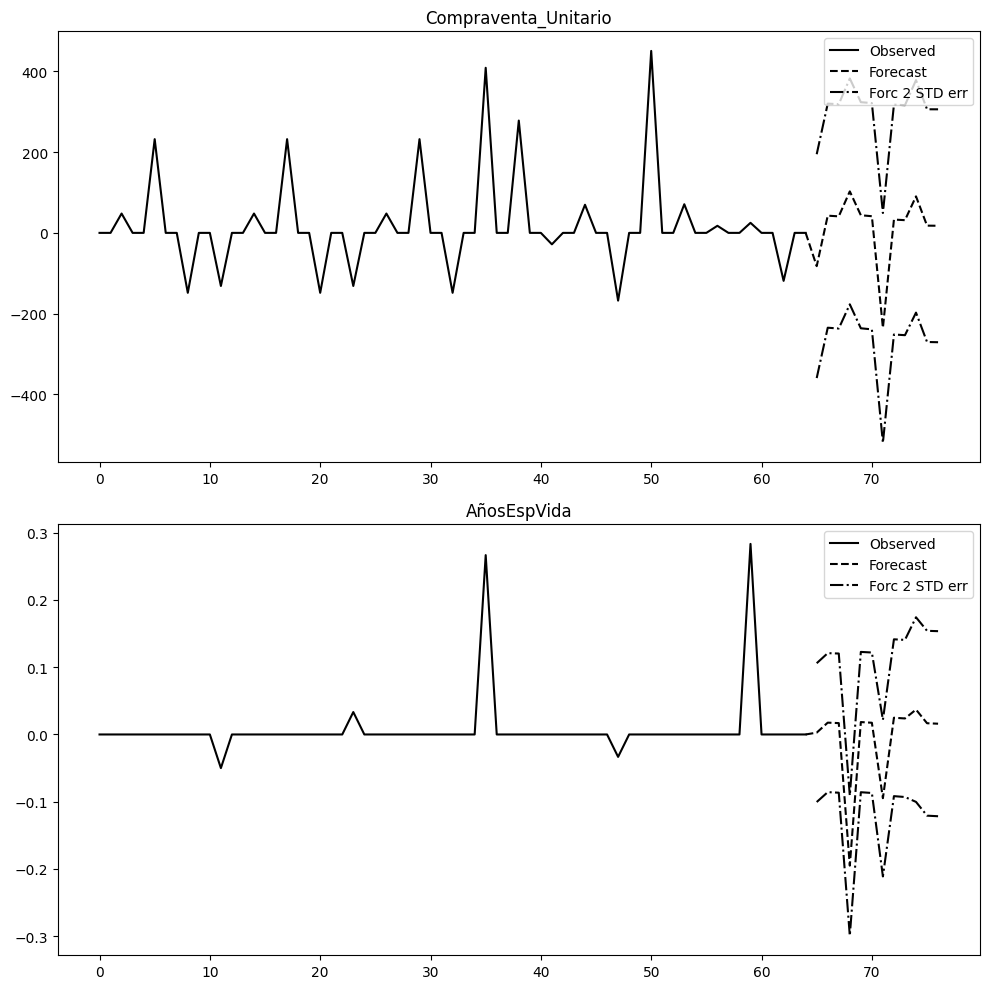

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [41]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [42]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,AñosEspVida
Fecha,,
2019-07-01,5253.793288,84.919401
2019-08-01,5296.446429,84.936980
2019-09-01,5337.405956,84.953861
2019-10-01,5440.242437,84.758851
2019-11-01,5483.970079,84.777295
2019-12-01,5525.261254,84.794717


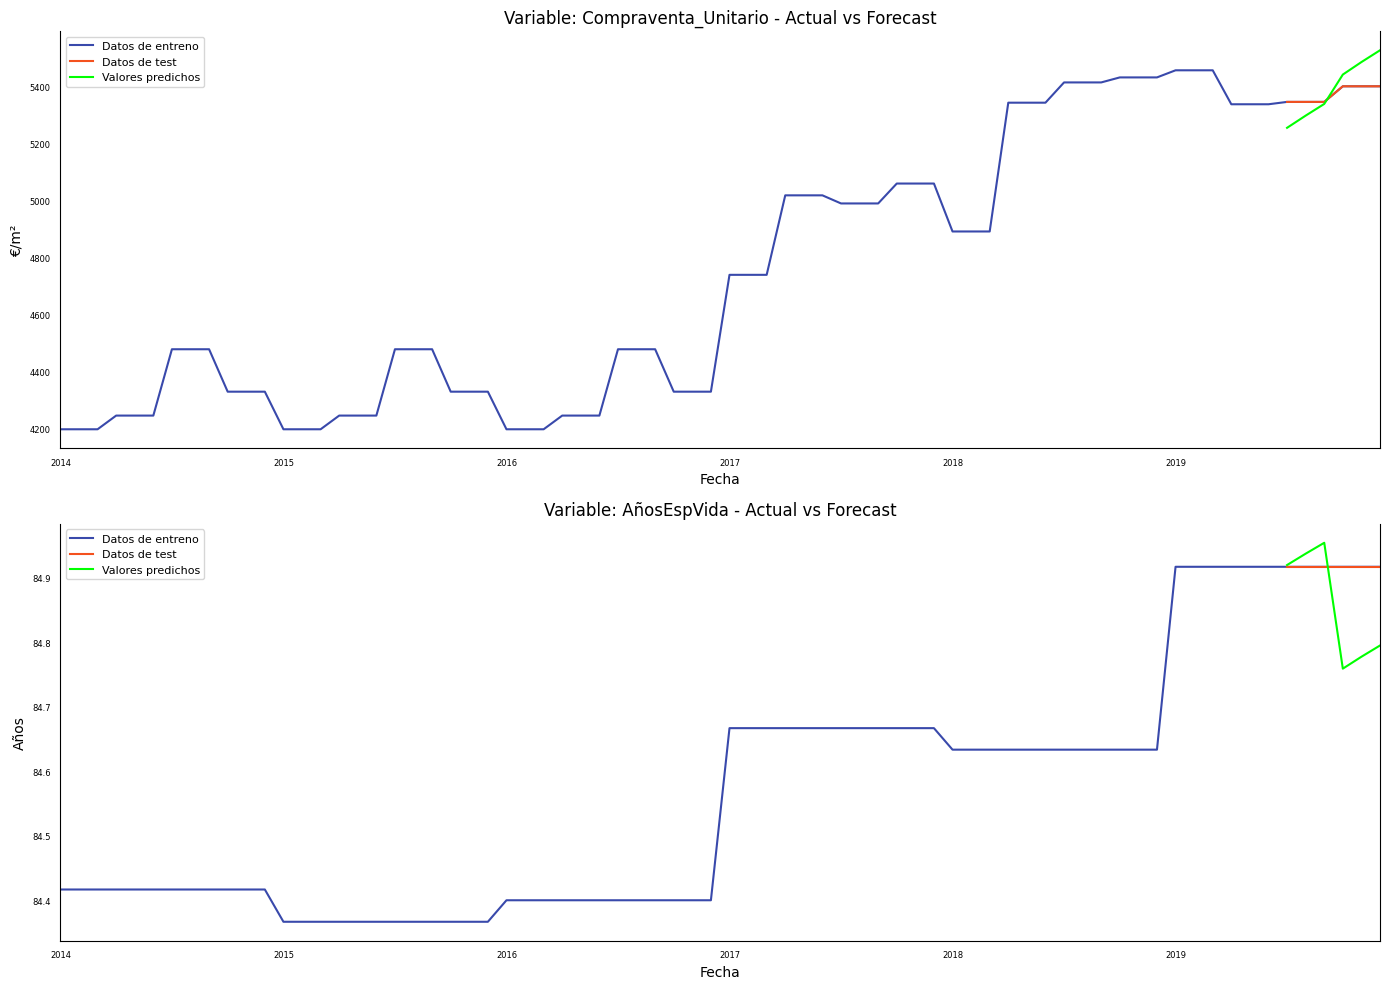

In [43]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Años']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    df[col].plot(color = '#3949AB', legend = True, ax = ax)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['Datos de entreno', 'Datos de test', 'Valores predichos'], loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [44]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [45]:
for i in ['Compraventa_Unitario','AñosEspVida']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 5894.310205344077
MAE is : 66.30468272191881
RMSE is : 76.77441113642017
MAPE is : 1.2326592978876596
R2 is : -6.8894693408828225

Evaluation metric for AñosEspVida
Evaluation metric results:-
MSE is : 0.010167599512721389
MAE is : 0.0798964727676174
RMSE is : 0.10083451548314887
MAPE is : 0.0940880935438085
R2 is : 0.0



Los resultados de las métricas de evaluación para Compraventa_Unitario indican un desempeño deficiente del modelo. Con un MSE de 35627.72, MAE de 174.55, RMSE de 188.75 y un R2 negativo de -14.60, se evidencia que las predicciones son poco precisas y el modelo no explica bien la variabilidad de los datos.

Para AñosEspVida, aunque el MSE y MAE son bajos (0.0636 y 0.2519 respectivamente), el R2 es extremadamente negativo (-3.15e+26), lo cual sugiere una mala capacidad del modelo para explicar los datos y posiblemente problemas graves en el ajuste del modelo. En resumen, ambos modelos necesitan mejoras significativas para ser útiles.

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 33.19228959734321
Root mean squared error: 54.287753558899404


### Modelo VARMA (Auto Arima)

El modelo VARMA (Vector Autoregressive Moving Average) es una técnica estadística utilizada en análisis de series temporales que combina los modelos VAR (Vector Autoregressive) y MA (Moving Average). Es especialmente útil cuando se trata de series temporales múltiples, permitiendo modelar la interdependencia entre varias series a lo largo del tiempo junto con términos de error autocorrelacionados.


In [47]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00


#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [48]:
import pmdarima as pm

In [49]:
pq = []
for name in ['Compraventa_Unitario', 'AñosEspVida']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=796.303, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=798.303, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=798.303, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=800.303, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=796.603, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.416 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : AñosEspVida
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-205.590, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-203.590, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-203.590, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-201.590, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-205.212, Time=0.05 sec

Best model:  ARIMA(0,0,0)(

In [50]:
pq

[(0, 0, 0), (0, 0, 0)]

- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMAX no incluye dependencia de los valores pasados de las variables en sí mismas.

- *q=0:* Indica que no hay términos de medias móviles en el modelo. Esto significa que no hay dependencia de los errores pasados del modelo en sí mismo.

En este caso no se puede aplicar el modelo VARMA, ya que el modelo esta considerando unicamente la tendencia lineal y no esta incorporando autocorrelacion en los residuos del modelo.


##Conclusiones

El análisis se centró en predecir eventos futuros relacionados con la compraventa de inmuebles y la esperanza de vida en el distrito de Sarrià-Sant Gervasi en Barcelona, utilizando modelos econométricos de series temporales multivariantes (VAR, VARMA, y VECM).

Importación y Preparación de Datos: Se cargaron y filtraron los datos, creando una variable de fecha y agrupándolos para el análisis.

Análisis Exploratorio: Se observó una alta correlación (89.5532%) entre la compraventa de unidades y la esperanza de vida.

Test de Cointegración: Las series no mostraron evidencia de estar cointegradas.
Prueba de Estacionariedad: Las series no eran estacionarias; se aplicó diferenciación hasta obtener series estacionarias.

Modelo VAR:
Se ajustó el modelo y se seleccionó el orden óptimo.
Las pruebas de causalidad de Granger indicaron que ninguna serie causa a la otra.
Los residuos del modelo eran ruido blanco, indicativo de un buen ajuste.
Evaluación del Modelo VAR:
Las métricas de evaluación (MSE, MAE, RMSE, R2) mostraron un mal desempeño.
Compraventa_Unitario: R2 de -14.60, indicando poca precisión.
AñosEspVida: R2 extremadamente negativo, sugiriendo problemas graves en el ajuste.

Modelo VARMA:
Auto Arima determinó que los valores óptimos de p y q no incluían autocorrelación, invalidando la aplicación del modelo VARMA.
En conclusión, los modelos utilizados mostraron limitaciones en su capacidad predictiva, indicando la necesidad de explorar otros enfoques para mejorar la precisión de las predicciones.